In [ ]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

In [39]:
%pylab inline


from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
CBB_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


def dtw(X, Y, metric='euclidean'):
    """
    
    Parameters
    ----------
    X : array_like
        M x D matrix
    Y : array_like
        N x D matrix    
    metric : string
             The distance metric to use. 
             Can be :
             'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
             'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski',
             'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao',
             'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
             'wminkowski', 'yule'.
             See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    Returns
    -------
    total_cost : float
                 Total (minimum) cost of warping
    pointwise_cost :  array_like
                      M x N matrix with cost at each (i, j)
    accumulated_cost : array_like
                       M x N matrix with (minimum) cost accumulated till (i,j)
                       having started from (0, 0)
        
    """
    
    X = np.array(X)
    Y = np.array(Y)
    if len(X.shape) == 1:
        # Reshape to N x 1 form
        X = X[:, np.newaxis]
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    # m = X length
    # n = Y length
    m, n = X.shape[0], Y.shape[0]
    D = np.zeros((m+1, n+1))
    D[1:, 0] = np.inf
    D[0, 1:] = np.inf
    D[1:,1:] = cdist(X, Y, metric)
    pointwise_cost = D[1:,1:].copy()
    for i in range(0, m):
        for j in range(0, n):
            cost = D[i+1, j+1]
            D[i+1, j+1] = cost + min (D[i, j+1], D[i+1, j], D[i, j])           
    accumulated_cost = D[1:, 1:]
    total_cost = D[m, n]/sum(D.shape)
    return total_cost, pointwise_cost, accumulated_cost


def get_path(D):
    """Traceback path of minimum cost 
    
    Given accumulated cost matrix D,
    trace back the minimum cost path
    
    Parameters
    -----------
    
    D : array_like
        M x N matrix as obtained from `accumulated_cost` using:
        total_cost, pointwise_cost, accumulated_cost = dtw(X, Y, metric='euclidean')
    
    Returns
    -------
    traceback_x, traceback_x : array_like
                               M x 1 and N x 1 array containing  indices of movement
                               starting from (0, 0) going to (M-1, N-1)
    """
    m , n = D.shape
    m = m - 1
    n = n - 1
    # Starting point is the end point
    traceback_x, traceback_y = [m], [n]
    while (m > 0 and n > 0):
        min_idx = np.argmin([D[m-1, n-1], D[m, n-1], D[m-1, n]])
        if min_idx == 0:
            # move diagonally
            m = m - 1
            n = n - 1
        elif min_idx == 1:
            # move vertically
            n = n - 1
        else:
            # move horizontally
            m = m - 1
        traceback_x.insert(0, m)
        traceback_y.insert(0, n)
    # End point is the starting point
    traceback_x.insert(0, 0)
    traceback_y.insert(0, 0)
    return np.array(traceback_x), np.array(traceback_y)

def plot_warped_timeseries(x, y, pointwise_cost, 
                           accumulated_cost, path, 
                           colormap=plt.cm.Blues,
                           linecolor=CBB_PALETTE[-2]):
    nullfmt = NullFormatter()    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    rect_heatmap = [left, bottom, width, height]
    rect_x = [left, bottom_h, width, 0.2]
    rect_y = [left_h, bottom, 0.2, height]

    fig = plt.figure(1, figsize=(8, 8))

    axHeatmap = plt.axes(rect_heatmap)
    axX = plt.axes(rect_x, sharex=axHeatmap)
    axY = plt.axes(rect_y, sharey=axHeatmap)

    # no labels
    axX.xaxis.set_major_formatter(nullfmt)
    axY.yaxis.set_major_formatter(nullfmt)
    
    axY.plot(y, range(0, len(y)), color="C0")
    axX.plot(x, color="C3")
    axHeatmap.imshow(accumulated_cost.T, 
                     origin='lower', 
                     cmap=colormap, 
                     interpolation='nearest')
    axHeatmap.plot(path[0], path[1], '-x', color=linecolor)
    #axHeatmap.xlim((-0.5, accumulated_cost.shape[0]-0.5))
    #axHeatmap.ylim((-0.5, accumulated_cost.shape[1]-0.5))
    return fig

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(-0.8, 16.8, -2.75, 2.75)

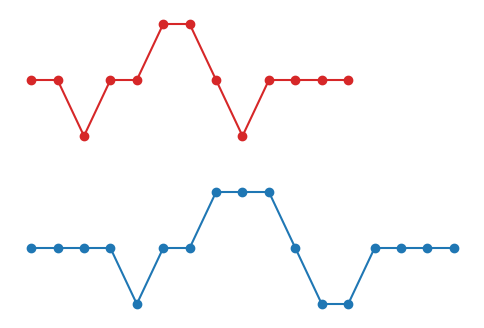

In [46]:
x = np.array([0,0,-1,0,0,1,1,0,-1,0,0,0,0])
y = np.array([0,0,0,0,-1,0,0,1,1,1,0,-1,-1,0,0,0,0])
plt.figure(figsize=(6, 4))
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")

(-0.8, 16.8, -2.75, 2.75)

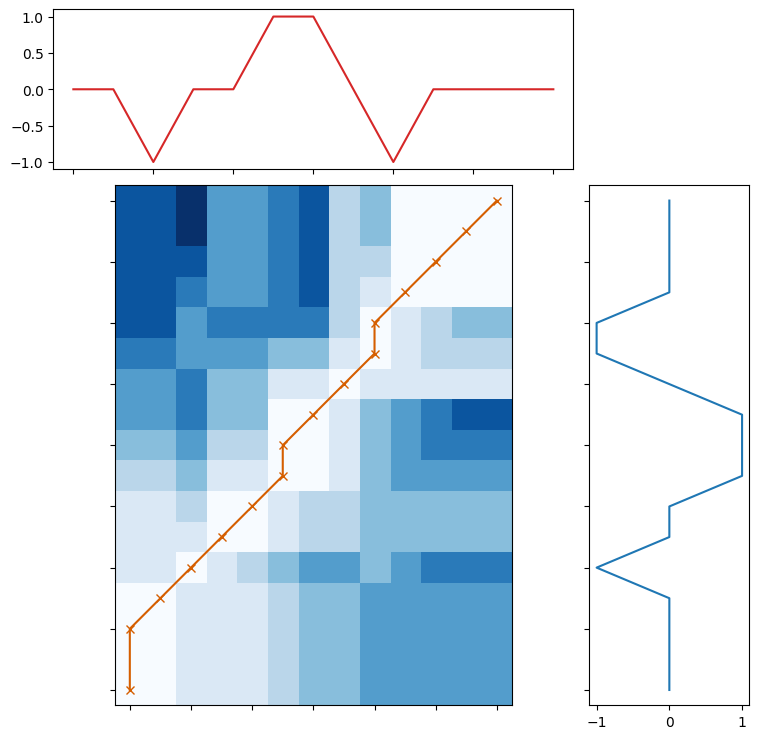

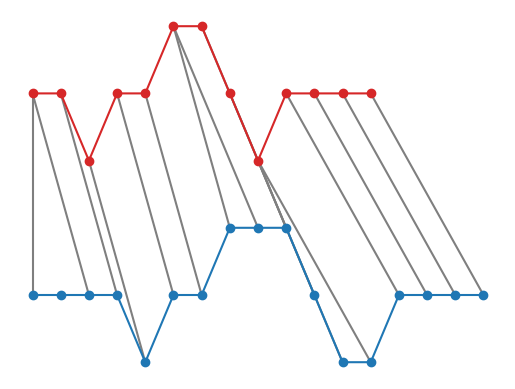

In [47]:
total_cost, pointwise_cost, accumulated_cost= dtw(x,y, 'euclidean')
path = get_path(accumulated_cost)
_ = plot_warped_timeseries(x, y, pointwise_cost, 
                           accumulated_cost, path)
plt.figure()
for traceback_x, traceback_y in zip(path[0], path[1]):
    plt.plot([traceback_x, traceback_y], [x[traceback_x] + 1.5, y[traceback_y] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")